# Computing the error between data and true model

## Import libraries

In [10]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint

## Define cell cycle model

In [2]:
# CELL CYCLE MODELS
### advanced_Ki67_cycle_model = 0
### basic_Ki67_cycle_model = 1
### flow_cytometry_cycle_model = 2
### live_apoptotic_cycle_model = 3
### total_cells_cycle_model = 4
### live_cells_cycle_model = 5 
### flow_cytometry_separated_cycle_model = 6
### cycling_quiescent_model = 7
cycle_model = 1

# output_folder = "output_Live/"
output_folder = "output_Ki67_Basic/"
# output_folder = "output_Ki67_Advanced/"
# output_folder = "output_Flow_Cytometry/"
# output_folder = "output_Separated_Flow_Cytometry/"

## Read *.csv* file

In [16]:
data_filename = "data_fraction.csv"

data = np.genfromtxt(output_folder + data_filename, dtype = float, delimiter = ',', names = True)
times = data["times"]

if cycle_model == 0:
    Ki67_negative_data = np.stack((data["Ki67_negative_mean"],), axis = -1);
    Ki67_positive_premitotic_data = np.stack((data["Ki67_positive_premitotic_mean"],), axis = -1);
    Ki67_positive_postmitotic_data = np.stack((data["Ki67_positive_postmitotic_mean"],), axis = -1);
elif cycle_model == 1:
    Ki67_negative_data = np.stack((data["Ki67_negative_mean"],), axis = -1);
    Ki67_positive_data = np.stack((data["Ki67_positive_mean"],), axis = -1);
elif cycle_model == 2:
    G0G1_phase_data = np.stack((data["G0G1_phase_mean"],), axis = -1);
    S_phase_data = np.stack((data["S_phase_mean"],), axis = -1);
    G2M_phase_data = np.stack((data["G2M_phase_mean"],), axis = -1);
elif cycle_model == 5:
    live_data = np.stack((data["live_mean"],), axis = -1);
elif cycle_model == 6:
    G0G1_phase_data = np.stack((data["G0G1_phase_mean"],), axis = -1);
    S_phase_data = np.stack((data["S_phase_mean"],), axis = -1);
    G2_phase_data = np.stack((data["G2_phase_mean"],), axis = -1);
    M_phase_data = np.stack((data["M_phase_mean"],), axis = -1);
else:
    print("Unrecognized cell cycle model.")
apoptotic_data = np.stack((data["apoptotic_mean"],), axis = -1);
necrotic_data = np.stack((data["necrotic_mean"],), axis = -1);

## Solve true model numerically

In [17]:
number_of_cells = 37

if cycle_model == 0:
    def true_model(X, t, r01, r10, r12, r20):
        Ki67_neg, Ki67_pos_pre, Ki67_pos_post = X
        dXdt = [-r01*Ki67_neg + r10*Ki67_pos_post,
            r01*Ki67_neg - r12*Ki67_pos_pre,
            2.0*r12*Ki67_pos_pre - r20*Ki67_pos_post
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0])
    r01 = 0.004604052
    r10 = 0.006666667
    r12 = 0.001282051
    r20 = 0.006666667
    true_solution = odeint(true_model, X0, times, args=(r01, r10, r12, r20))
elif cycle_model == 1:
    def true_model(X, t, r01, r10):
        Ki67_neg, Ki67_pos = X
        dXdt = [-r01*Ki67_neg + 2.0*r10*Ki67_pos, 
            r01*Ki67_neg - r10*Ki67_pos
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0])
    r01 = 0.003631082
    r10 = 0.001075269
    true_solution = odeint(true_model, X0, times, args=(r01, r10))
elif cycle_model == 2:
    def true_model(X, t, r01, r20, r12):
        G0G1, S, G2M = X
        dXdt = [-r01*G0G1 + 2.0*r20*G2M,
            r01*G0G1 - r12*S,
            r12*S - r20*G2M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0])
    r01 = 0.003236246
    r20 = 0.003333333
    r12 = 0.002083333
    true_solution = odeint(true_model, X0, times, args=(r01, r20, r12))
elif cycle_model == 5:
    def true_model(X, t, b):
        live = X
        dXdt = b*live
        return dXdt
    
    X0 = np.array([number_of_cells])
    b = 0.0007198228
    true_solution = odeint(true_model, X0, times, args=(b,))
elif cycle_model == 6:
    def true_model(X, t, r01, r30, r12, r23):
        G0G1, S, G2, M = X
        dXdt = [-r01*G0G1 + 2.0*r30*M,
            r01*G0G1 - r12*S,
            r12*S - r23*G2,
            r23*G2 - r30*M
        ]
        return dXdt
    
    X0 = np.array([number_of_cells, 0, 0, 0])
    r01 = 0.00334672
    r30 = 0.016666667
    r12 = 0.002083333
    r23 = 0.004166667
    true_solution = odeint(true_model, X0, times, args=(r01, r30, r12, r23))
else:
    print("Unrecognized cell cycle model.")

## Compute tumor cell fraction for the true model

In [20]:
total_true = np.sum(true_solution, axis=1)

if cycle_model == 0:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_premitotic_true = true_solution[:,1]/total_true;
    Ki67_positive_postmitotic_true = true_solution[:,2]/total_true;
elif cycle_model == 1:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_true = true_solution[:,1]/total_true;
elif cycle_model == 2:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2M_phase_true = true_solution[:,2]/total_true;
elif cycle_model == 5:
    live_true = true_solution[:,0]/total_true;
elif cycle_model == 6:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2_phase_true = true_solution[:,2]/total_true;
    M_phase_true = true_solution[:,3]/total_true;
else:
    print("Unrecognized cell cycle model.")

## Compute cumulative sum of squared errors between data and true model

In [23]:
def compute_CSSE(target, predicted):
    squared_errors = (target - predicted)**2.0
    return np.cumsum(squared_errors)

In [33]:
if cycle_model == 0:
    Ki67_negative_csse = compute_CSSE(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_premitotic_csse = compute_CSSE(Ki67_positive_premitotic_true.flatten(), Ki67_positive_premitotic_data.flatten());
    Ki67_positive_postmitotic_csse = compute_CSSE(Ki67_positive_postmitotic_true.flatten(), Ki67_positive_postmitotic_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([Ki67_negative_csse[-1], Ki67_positive_premitotic_csse[-1], Ki67_positive_postmitotic_csse[-1]])) + "\n")
elif cycle_model == 1:
    Ki67_negative_csse = compute_CSSE(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_csse = compute_CSSE(Ki67_positive_true.flatten(), Ki67_positive_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([Ki67_negative_csse[-1], Ki67_positive_csse[-1]])) + "\n")
elif cycle_model == 2:
    G0G1_phase_csse = compute_CSSE(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_csse = compute_CSSE(S_phase_true.flatten(), S_phase_data.flatten());
    G2M_phase_csse = compute_CSSE(G2M_phase_true.flatten(), G2M_phase_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([G0G1_phase_csse[-1], S_phase_csse[-1], G2M_phase_csse[-1]])) + "\n")
elif cycle_model == 5:
    live_csse = compute_CSSE(live_true.flatten(), live_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([live_csse[-1]])) + "\n")
elif cycle_model == 6:
    G0G1_phase_csse = compute_CSSE(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_csse = compute_CSSE(S_phase_true.flatten(), S_phase_data.flatten());
    G2_phase_csse = compute_CSSE(G2_phase_true.flatten(), G2_phase_data.flatten());
    M_phase_csse = compute_CSSE(M_phase_true.flatten(), M_phase_data.flatten());
    
    print("SSE between data and true model = " + str(np.array([G0G1_phase_csse[-1], S_phase_csse[-1], G2_phase_csse[-1], M_phase_csse[-1]])) + "\n")
else:
    print("Unrecognized cell cycle model.")

SSE between data and true model = [0.05005506 0.05005506]



## Plot cumulative sum of squared errors

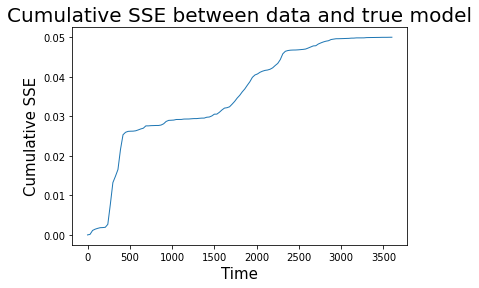

In [37]:
plt.clf()
if cycle_model == 0:
    plt.plot(times, Ki67_negative_csse, alpha = 1.0, linewidth = 1)
elif cycle_model == 1:
    plt.plot(times, Ki67_negative_csse, alpha = 1.0, linewidth = 1)
elif cycle_model == 2:
    plt.plot(times, G0G1_phase_csse, alpha = 1.0, linewidth = 1)
elif cycle_model == 5:
    plt.plot(times, live_csse, alpha = 1.0, linewidth = 1)
elif cycle_model == 6:
    plt.plot(times, G0G1_phase_csse, alpha = 1.0, linewidth = 1)
else:
    print("Unrecognized cell cycle model.")
    
plt.title( 'Cumulative SSE between data and true model', size=20)
plt.xlabel( 'Time', size=15 ) 
plt.ylabel( 'Cumulative SSE', size=15 )
plt.savefig(os.path.join(output_folder, "csse.png"), bbox_inches = 'tight')

## Write a *.csv* output file

In [38]:
if cycle_model == 0:
    output_array = np.column_stack((times.flatten(), Ki67_negative_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 1:
    output_array = np.column_stack((times.flatten(), Ki67_negative_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 2:
    output_array = np.column_stack((times.flatten(), G0G1_phase_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 5:
    output_array = np.column_stack((times.flatten(), live_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 6:
    output_array = np.column_stack((times.flatten(), G0G1_phase_csse.flatten()))
    np.savetxt(os.path.join(output_folder, "csse.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
else:
    print("Unrecognized cell cycle model.")

## Compute absolute error between data and true model

In [53]:
def compute_absolute_error(target, predicted):
    absolute_errors = abs(target - predicted)
    return np.cumsum(absolute_errors)

In [54]:
if cycle_model == 0:
    Ki67_negative_absolute_error = compute_absolute_error(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_premitotic_absolute_error = compute_absolute_error(Ki67_positive_premitotic_true.flatten(), Ki67_positive_premitotic_data.flatten());
    Ki67_positive_postmitotic_absolute_error = compute_absolute_error(Ki67_positive_postmitotic_true.flatten(), Ki67_positive_postmitotic_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([Ki67_negative_absolute_error[-1], Ki67_positive_premitotic_absolute_error[-1], Ki67_positive_postmitotic_absolute_error[-1]])) + "\n")
elif cycle_model == 1:
    Ki67_negative_absolute_error = compute_absolute_error(Ki67_negative_true.flatten(), Ki67_negative_data.flatten());
    Ki67_positive_absolute_error = compute_absolute_error(Ki67_positive_true.flatten(), Ki67_positive_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([Ki67_negative_absolute_error[-1], Ki67_positive_absolute_error[-1]])) + "\n")
elif cycle_model == 2:
    G0G1_phase_absolute_error = compute_absolute_error(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_absolute_error = compute_absolute_error(S_phase_true.flatten(), S_phase_data.flatten());
    G2M_phase_absolute_error = compute_absolute_error(G2M_phase_true.flatten(), G2M_phase_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([G0G1_phase_absolute_error[-1], S_phase_absolute_error[-1], G2M_phase_absolute_error[-1]])) + "\n")
elif cycle_model == 5:
    live_absolute_error = compute_absolute_error(live_true.flatten(), live_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([live_absolute_error[-1]])) + "\n")
elif cycle_model == 6:
    G0G1_phase_absolute_error = compute_absolute_error(G0G1_phase_true.flatten(), G0G1_phase_data.flatten());
    S_phase_absolute_error = compute_absolute_error(S_phase_true.flatten(), S_phase_data.flatten());
    G2_phase_absolute_error = compute_absolute_error(G2_phase_true.flatten(), G2_phase_data.flatten());
    M_phase_absolute_error = compute_absolute_error(M_phase_true.flatten(), M_phase_data.flatten());
    
    print("Absolute error between data and true model = " + str(np.array([G0G1_phase_absolute_error[-1], S_phase_absolute_error[-1], G2_phase_absolute_error[-1], M_phase_absolute_error[-1]])) + "\n")
else:
    print("Unrecognized cell cycle model.")

Absolute error between data and true model = [1.78838558 1.78838558]



## Plot absolute error

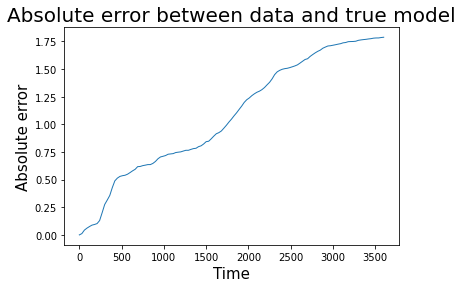

In [55]:
plt.clf()
if cycle_model == 0:
    plt.plot(times, Ki67_negative_absolute_error, alpha = 1.0, linewidth = 1)
elif cycle_model == 1:
    plt.plot(times, Ki67_negative_absolute_error, alpha = 1.0, linewidth = 1)
elif cycle_model == 2:
    plt.plot(times, G0G1_phase_absolute_error, alpha = 1.0, linewidth = 1)
elif cycle_model == 5:
    plt.plot(times, live_absolute_error, alpha = 1.0, linewidth = 1)
elif cycle_model == 6:
    plt.plot(times, G0G1_phase_absolute_error, alpha = 1.0, linewidth = 1)
else:
    print("Unrecognized cell cycle model.")
    
plt.title( 'Absolute error between data and true model', size=20)
plt.xlabel( 'Time', size=15 ) 
plt.ylabel( 'Absolute error', size=15 )
plt.savefig(os.path.join(output_folder, "absolute_error.png"), bbox_inches = 'tight')

## Write a *.csv* output file

In [56]:
if cycle_model == 0:
    output_array = np.column_stack((times.flatten(), Ki67_negative_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 1:
    output_array = np.column_stack((times.flatten(), Ki67_negative_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 2:
    output_array = np.column_stack((times.flatten(), G0G1_phase_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 5:
    output_array = np.column_stack((times.flatten(), live_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
elif cycle_model == 6:
    output_array = np.column_stack((times.flatten(), G0G1_phase_absolute_error.flatten()))
    np.savetxt(os.path.join(output_folder, "absolute_error.csv"), output_array, delimiter=',', fmt='%.8f',
               header="times, tumor_cell_fraction_error", comments='')
else:
    print("Unrecognized cell cycle model.")